### Import libraries

In [2]:
import uproot
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.fftpack import fft,  ifft, fftfreq, fftshift, dct, idct

def getRMS(arr):    return np.sqrt(np.mean(np.asarray(arr)**2, axis=0))

### Extract data

In [3]:
inFile = '../data/input/BetaMeas_Lab2.root'
treeName = 'wfm'
branchNameAmplitude = 'w3'
branchNameTime = 't3'
dt = 0.1 # ns

In [4]:
inData = uproot.open(inFile)[treeName]
Amplitude_arr = inData[f'{branchNameAmplitude}'].array(library="np")
Time_arr = inData[f'{branchNameTime}'].array(library="np")

In [5]:
Amplitude_arr
Amplitude_arr[0][:20]

array([ 1.59053418e-03,  1.40928235e-03, -1.01290122e-03, -2.14160580e-03,
       -2.42548631e-05, -4.07323023e-05, -2.77598721e-03, -1.24358536e-03,
        2.28258663e-03,  1.72235369e-03,  1.17859820e-03,  1.29394027e-03,
        2.06429286e-04,  4.28874715e-04,  5.52455509e-04,  2.72339043e-04,
        3.95919837e-04, -1.44955335e-03, -2.80070337e-03, -7.73978347e-04])

### Draw first three events

RMS = 0.0020044273034552033 mV


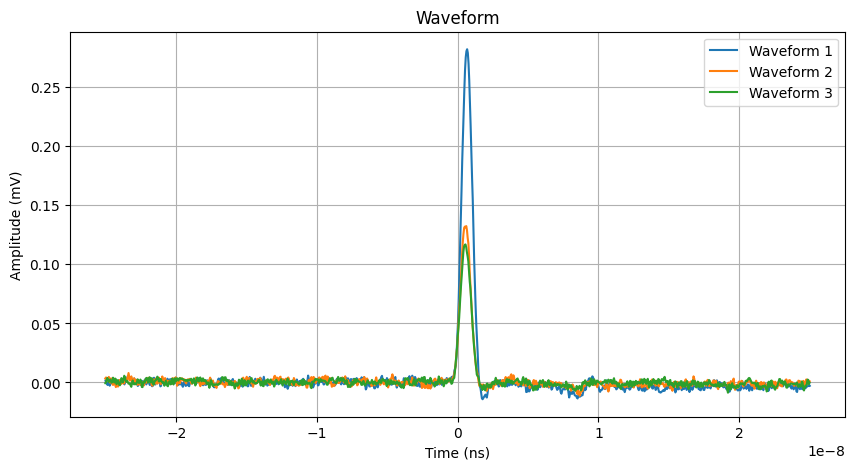

In [6]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(Time_arr[0], Amplitude_arr[0], label='Waveform 1')
ax.plot(Time_arr[1], Amplitude_arr[1], label='Waveform 2')
ax.plot(Time_arr[2], Amplitude_arr[2], label='Waveform 3')
ax.set_xlabel('Time (ns)')
ax.set_ylabel('Amplitude (mV)')
ax.set_title('Waveform')
ax.grid(True)
ax.legend()

# get the RMS of an array
signalRMS = getRMS(Amplitude_arr[0][20:220])
print(f'RMS = {signalRMS} mV')

plt.show()

### FFT of first signal

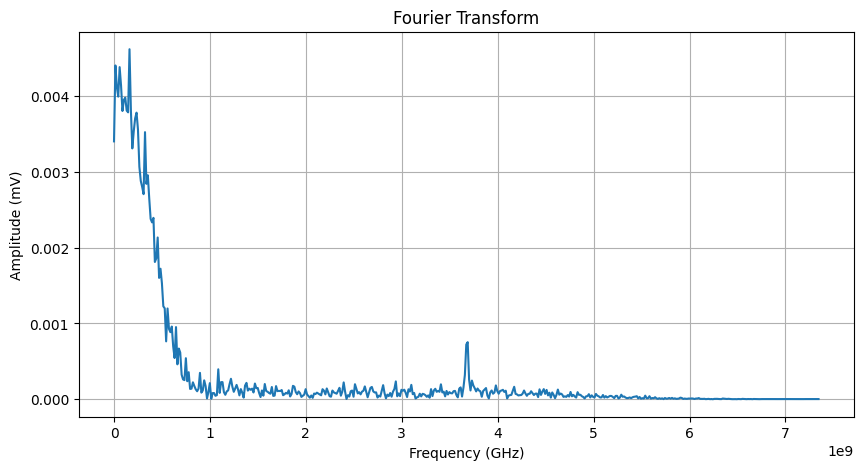

In [11]:
fft_amplitude = fft(Amplitude_arr[3])
xf = fftfreq(len(Amplitude_arr[3]), Time_arr[3][1] - Time_arr[2][0])
df_fft = pd.DataFrame({'Frequency': xf, 'Amplitude': fft_amplitude})

def getAmplitude(fft_amplitude):    return 2.0/len(Amplitude_arr[3]) * np.abs(fft_amplitude[0:len(Amplitude_arr[3])//2])

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(xf[:len(Amplitude_arr[0])//2], 2.0/len(Amplitude_arr[3]) * np.abs(fft_amplitude[0:len(Amplitude_arr[3])//2]))
ax.set_xlabel('Frequency (GHz)')
ax.set_ylabel('Amplitude (mV)')
#ax.set_ylim(0, 0.001)
ax.set_title('Fourier Transform')
ax.grid(True)
plt.show()

### Remove noisy frequencies

Frequency with maximum amplitude = (0.36873020836644194+0j) GHz
Frequency range: (0.3587302083664419+0j) - (0.37873020836644194+0j) GHz


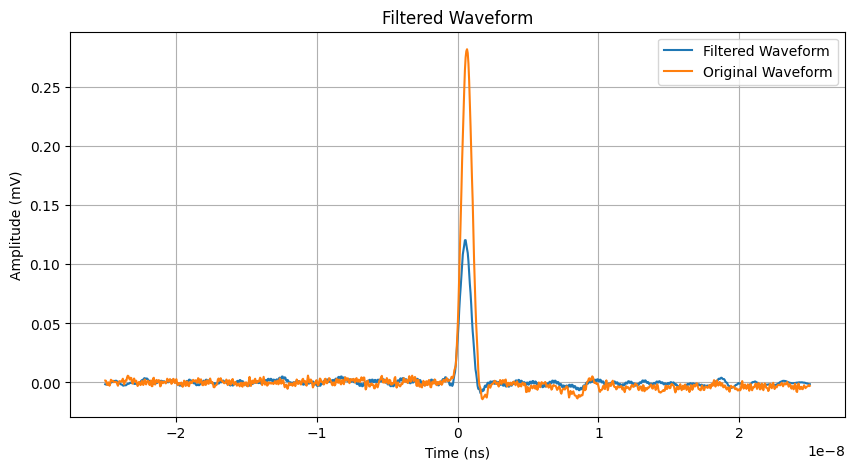

RMS = 0.0014714487685382267 mV
Old RMS = 0.0020044273034552033 mV


In [15]:
# find the frequency with the maximum amplitude away from initial noise
idmax_ampl = df_fft.query('Frequency > 0.1e10', inplace=False)['Amplitude'].idxmax()
freq_max = df_fft.iloc[idmax_ampl]['Frequency']
amplitude_th =df_fft.iloc[idmax_ampl]['Amplitude']*0.9
freq_window = 0.01e10
print(f'Frequency with maximum amplitude = {(freq_max)*1e-10} GHz')
print(f'Frequency range: {(freq_max-freq_window)*1e-10} - {(freq_max+freq_window)*1e-10} GHz')

fft_amplitude_filtered = np.copy(fft_amplitude)
# filter the signal requiring the frequency to be between freq_low_th and freq_high_th 
freq_low_th = np.real(freq_max - freq_window)
freq_high_th = np.real(freq_max + freq_window)
fft_amplitude_filtered[(np.abs(df_fft['Frequency']) < freq_low_th) & (np.abs(df_fft['Frequency']) > freq_high_th)] = 0 
#require that the amplitude is above the threshold
fft_amplitude_filtered[np.abs(fft_amplitude_filtered) < amplitude_th] = 0

filtered_signal = np.real(ifft(fft_amplitude_filtered))

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(Time_arr[0], filtered_signal, label='Filtered Waveform')
ax.plot(Time_arr[0], Amplitude_arr[0], label='Original Waveform')
ax.set_xlabel('Time (ns)')
ax.set_ylabel('Amplitude (mV)')
ax.set_title('Filtered Waveform')
ax.grid(True)
ax.legend()
plt.show()

# get the RMS of an array
signalRMS = getRMS(filtered_signal[20:220])
print(f'RMS = {signalRMS} mV')
print(f'Old RMS = {getRMS(Amplitude_arr[0][20:220])} mV')
